In [13]:
import numpy as np
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

client = MongoClient('localhost:27017')
db = client.hiwi
collection = db.production_steps

database = {}
database['features'] = {}
index = []

query_1 = {"$and": [{"type": "formation"}, {"substep": "soacking"}, {"features": {"$exists": True}}]}
query_1 = list(collection.find(query_1))
database['features']['soacking_state'] = []
database['features']['soacking_success'] = []
database['features']['soacking_start_voltage'] = []
for i in range(len(query_1)):
    database['features']['soacking_state'].append(query_1[i]['features'][0]['value'])
    database['features']['soacking_success'].append(query_1[i]['features'][1]['value'])
    database['features']['soacking_start_voltage'].append(query_1[i]['features'][2]['value'])
    index.append(query_1[i]['cell_id'])

query_2 = {"$and": [{"type": "formation"}, {"substep": "precharge"}, {"features": {"$exists": True}}]}
query_2 = list(collection.find(query_2))
database['features']['precharge_start_voltage'] = []
database['features']['precharge_duration'] = []
database['features']['precharge_energy'] = []
database['features']['precharge_success'] = []
database['features']['precharge_continuity'] = []
for i in range(len(query_2)):
    database['features']['precharge_start_voltage'].append(query_2[i]['features'][0]['value'])
    database['features']['precharge_duration'].append(query_2[i]['features'][1]['value'])
    database['features']['precharge_energy'].append(query_2[i]['features'][2]['value'])
    database['features']['precharge_success'].append(query_2[i]['features'][3]['value'])
    database['features']['precharge_continuity'].append(query_2[i]['features'][4]['value'])

query_3 = {"$and": [{"type": "formation"}, {"substep": "charge"}, {"features": {"$exists": True}}]}
query_3 = list(collection.find(query_3))
database['features']['charge_start_voltage'] = []
database['features']['charge_duration'] = []
database['features']['charge_energy'] = []
database['features']['charge_success'] = []
database['features']['charge_continuity'] = []
for i in range(len(query_3)):
    database['features']['charge_start_voltage'].append(query_3[i]['features'][0]['value'])
    database['features']['charge_duration'].append(query_3[i]['features'][1]['value'])
    database['features']['charge_energy'].append(query_3[i]['features'][2]['value'])
    database['features']['charge_success'].append(query_3[i]['features'][3]['value'])
    database['features']['charge_continuity'].append(query_3[i]['features'][4]['value'])

query_4 = {"$and": [{"type": "formation"}, {"substep": "discharge"}, {"features": {"$exists": True}}]}
query_4 = list(collection.find(query_4))
database['features']['discharge_start_voltage'] = []
database['features']['discharge_duration'] = []
database['features']['discharge_energy'] = []
database['features']['discharge_success'] = []
database['features']['discharge_continuity'] = []
for i in range(len(query_4)):
    database['features']['discharge_start_voltage'].append(query_4[i]['features'][0]['value'])
    database['features']['discharge_duration'].append(query_4[i]['features'][1]['value'])
    database['features']['discharge_energy'].append(query_4[i]['features'][2]['value'])
    database['features']['discharge_success'].append(query_4[i]['features'][3]['value'])
    database['features']['discharge_continuity'].append(query_4[i]['features'][4]['value'])

data_formation = pd.DataFrame(database['features'])

class_le = LabelEncoder()
for column in data_formation[['soacking_state', 'precharge_continuity', 'charge_continuity', 'discharge_continuity', 'soacking_success', 'precharge_success', 'charge_success', 'discharge_success']].columns:
    data_formation[column] = class_le.fit_transform(data_formation[column].values)

# get all features and store them into dataframe
data_formation['index'] = index
data_formation = data_formation.sort_values(by = ['index'])
data_formation = data_formation.drop(['index'], axis = 1)

data_temp = list(collection.find({"features": {"$exists": True}}))
data = pd.DataFrame(data_temp)

database = {}
database['conditioning_features'] = {}
index = []

for k in range(2):
    database['conditioning_features'][str(k)] = {}
    database['conditioning_features']['0']['conditioning_0_step_1_mean_voltage'] = []
    database['conditioning_features'][str(k)]['conditioning_' + str(k) + '_step_3_start_voltage'] = []
    database['conditioning_features'][str(k)]['conditioning_' + str(k) + '_step_3_duration'] = []
    database['conditioning_features'][str(k)]['conditioning_' + str(k) + '_step_3_energy'] = []
    database['conditioning_features'][str(k)]['conditioning_' + str(k) + '_step_3_r_dc_step'] = []
    database['conditioning_features'][str(k)]['conditioning_' + str(k) + '_step_3_r_dc'] = []
    database['conditioning_features'][str(k)]['conditioning_' + str(k) + '_step_4_start_voltage'] = []
    database['conditioning_features'][str(k)]['conditioning_' + str(k) + '_step_4_duration'] = []
    database['conditioning_features'][str(k)]['conditioning_' + str(k) + '_step_4_energy'] = []
    database['conditioning_features'][str(k)]['conditioning_' + str(k) + '_step_5_start_voltage'] = []
    database['conditioning_features'][str(k)]['conditioning_' + str(k) + '_step_5_duration'] = []
    database['conditioning_features'][str(k)]['conditioning_' + str(k) + '_step_5_energy'] = []
    database['conditioning_features'][str(k)]['conditioning_' + str(k) + '_step_6_start_voltage'] = []
    database['conditioning_features'][str(k)]['conditioning_' + str(k) + '_step_6_duration'] = []
    database['conditioning_features'][str(k)]['conditioning_' + str(k) + '_step_6_energy'] = []

for i in range(len(data_temp)):
    if data_temp[i]["cell_id"] != "Q_206":
        if data_temp[i]['substep'] == "cycle_0_step_1":
            database['conditioning_features']['0']['conditioning_0_step_1_mean_voltage'].append((data_temp[i]['features'][0]['value']))
            index.append(data_temp[i]['cell_id'])
        if data_temp[i]['substep'] == "cycle_0_step_3":
            if data_temp[i]['features'][0]['type'] == "start_voltage":
                database['conditioning_features']['0']['conditioning_0_step_3_start_voltage'].append((data_temp[i]['features'][0]['value']))
            if data_temp[i]['features'][1]['type'] == "duration":
                database['conditioning_features']['0']['conditioning_0_step_3_duration'].append((data_temp[i]['features'][1]['value']))
            if data_temp[i]['features'][2]['type'] == "energy":
                database['conditioning_features']['0']['conditioning_0_step_3_energy'].append((data_temp[i]['features'][2]['value']))
            if data_temp[i]['features'][3]['type'] == "r_dc_step":
                database['conditioning_features']['0']['conditioning_0_step_3_r_dc_step'].append((data_temp[i]['features'][3]['value']))
            if data_temp[i]['features'][4]['type'] == "r_dc":
                database['conditioning_features']['0']['conditioning_0_step_3_r_dc'].append((data_temp[i]['features'][4]['value']))
        if data_temp[i]['substep'] == "cycle_0_step_4":
            if data_temp[i]['features'][0]['type'] == "start_voltage":
                database['conditioning_features']['0']['conditioning_0_step_4_start_voltage'].append((data_temp[i]['features'][0]['value']))
            if data_temp[i]['features'][1]['type'] == "duration":
                database['conditioning_features']['0']['conditioning_0_step_4_duration'].append((data_temp[i]['features'][1]['value']))
            if data_temp[i]['features'][2]['type'] == "energy":
                database['conditioning_features']['0']['conditioning_0_step_4_energy'].append((data_temp[i]['features'][2]['value']))
        if data_temp[i]['substep'] == "cycle_0_step_5":
            if data_temp[i]['features'][0]['type'] == "start_voltage":
                database['conditioning_features']['0']['conditioning_0_step_5_start_voltage'].append((data_temp[i]['features'][0]['value']))
            if data_temp[i]['features'][1]['type'] == "duration":
                database['conditioning_features']['0']['conditioning_0_step_5_duration'].append((data_temp[i]['features'][1]['value']))
            if data_temp[i]['features'][2]['type'] == "energy":
                database['conditioning_features']['0']['conditioning_0_step_5_energy'].append((data_temp[i]['features'][2]['value']))
        if data_temp[i]['substep'] == "cycle_0_step_6":
            if data_temp[i]['features'][0]['type'] == "start_voltage":
                database['conditioning_features']['0']['conditioning_0_step_6_start_voltage'].append((data_temp[i]['features'][0]['value']))
            if data_temp[i]['features'][1]['type'] == "duration":
                database['conditioning_features']['0']['conditioning_0_step_6_duration'].append((data_temp[i]['features'][1]['value']))
            if data_temp[i]['features'][2]['type'] == "energy":
                database['conditioning_features']['0']['conditioning_0_step_6_energy'].append((data_temp[i]['features'][2]['value']))
        if data_temp[i]['substep'] == "cycle_1_step_3":
            if data_temp[i]['features'][0]['type'] == "start_voltage":
                database['conditioning_features']['1']['conditioning_1_step_3_start_voltage'].append((data_temp[i]['features'][0]['value']))
            if data_temp[i]['features'][1]['type'] == "duration":
                database['conditioning_features']['1']['conditioning_1_step_3_duration'].append((data_temp[i]['features'][1]['value']))
            if data_temp[i]['features'][2]['type'] == "energy":
                database['conditioning_features']['1']['conditioning_1_step_3_energy'].append((data_temp[i]['features'][2]['value']))
            if data_temp[i]['features'][3]['type'] == "r_dc_step":
                database['conditioning_features']['1']['conditioning_1_step_3_r_dc_step'].append((data_temp[i]['features'][3]['value']))
            if data_temp[i]['features'][4]['type'] == "r_dc":
                database['conditioning_features']['1']['conditioning_1_step_3_r_dc'].append((data_temp[i]['features'][4]['value']))
        if data_temp[i]['substep'] == "cycle_1_step_4":
            if data_temp[i]['features'][0]['type'] == "start_voltage":
                database['conditioning_features']['1']['conditioning_1_step_4_start_voltage'].append((data_temp[i]['features'][0]['value']))
            if data_temp[i]['features'][1]['type'] == "duration":
                database['conditioning_features']['1']['conditioning_1_step_4_duration'].append((data_temp[i]['features'][1]['value']))
            if data_temp[i]['features'][2]['type'] == "energy":
                database['conditioning_features']['1']['conditioning_1_step_4_energy'].append((data_temp[i]['features'][2]['value']))
        if data_temp[i]['substep'] == "cycle_1_step_5":
            if data_temp[i]['features'][0]['type'] == "start_voltage":
                database['conditioning_features']['1']['conditioning_1_step_5_start_voltage'].append((data_temp[i]['features'][0]['value']))
            if data_temp[i]['features'][1]['type'] == "duration":
                database['conditioning_features']['1']['conditioning_1_step_5_duration'].append((data_temp[i]['features'][1]['value']))
            if data_temp[i]['features'][2]['type'] == "energy":
                database['conditioning_features']['1']['conditioning_1_step_5_energy'].append((data_temp[i]['features'][2]['value']))
        if data_temp[i]['substep'] == "cycle_1_step_6":
            if data_temp[i]['features'][0]['type'] == "start_voltage":
                database['conditioning_features']['1']['conditioning_1_step_6_start_voltage'].append((data_temp[i]['features'][0]['value']))
            if data_temp[i]['features'][1]['type'] == "duration":
                database['conditioning_features']['1']['conditioning_1_step_6_duration'].append((data_temp[i]['features'][1]['value']))
            if data_temp[i]['features'][2]['type'] == "energy":
                database['conditioning_features']['1']['conditioning_1_step_6_energy'].append((data_temp[i]['features'][2]['value']))


data_0 = pd.DataFrame(database['conditioning_features']['0'])
data_1 = pd.DataFrame(database['conditioning_features']['1'])
data_conditioning = pd.concat([data_0, data_1], axis=1, join='inner')

data_conditioning['index'] = index
data_conditioning = data_conditioning.sort_values(by = ['index'])
data_conditioning = data_conditioning.drop(['index'], axis = 1)

data = pd.concat([data_formation, data_conditioning], axis=1, join='inner')

# apply pca
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(data)

pca = PCA(n_components=7)
pca.fit(segmentation_std)
scores_pca = pca.transform(segmentation_std)

data_pca = pd.concat([data.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
data_pca.columns.values[-7: ] = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7']
data = data_pca[['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7']]

In [14]:
data.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7
0,-6.223389,-8.951986,7.849757,4.138052,1.795698,2.523308,0.438677
1,5.072399,-1.784843,2.227416,-1.208397,0.209068,-0.632336,-0.042383
2,3.067988,-1.774170,0.775395,0.199682,-1.758906,-0.525038,-0.774666
3,2.921080,-1.077650,0.774054,-1.306831,0.083818,-1.104132,-0.130032
4,0.953907,-1.119244,0.255681,0.479206,0.037144,-0.671199,1.664375


In [22]:
labels = pd.read_csv("/Users/rampageyao/Desktop/labels.csv", delimiter=";")
labels = (labels.iloc[:, 1]).tolist()
data['qdot_labels'] = labels
data.head()

<ipython-input-22-2315ac149bef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['qdot_labels'] = labels


,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,qdot_labels
0,-6.223389,-8.951986,7.849757,4.138052,1.795698,2.523308,0.438677,1
1,5.072399,-1.784843,2.227416,-1.208397,0.209068,-0.632336,-0.042383,1
2,3.067988,-1.774170,0.775395,0.199682,-1.758906,-0.525038,-0.774666,1
3,2.921080,-1.077650,0.774054,-1.306831,0.083818,-1.104132,-0.130032,1
4,0.953907,-1.119244,0.255681,0.479206,0.037144,-0.671199,1.664375,1


In [24]:
sc = StandardScaler()
train, test = train_test_split(data, test_size=0.33)
X_train, y_train = train.iloc[:, 0:7], train.iloc[:, 7]
X_test, y_test = test.iloc[:, 0:7], test.iloc[:, 7]


In [25]:
ranFor = RandomForestClassifier()
grid=[{'n_estimators':[3,5,8,10,13,15,18,20,25,40,60,80,100],'max_features':['auto','sqrt'],'max_depth':[None,1,3,5,7,10,15,20]}]
ranFor_CV=GridSearchCV(ranFor,grid,cv=10)
ranFor_CV.fit(X_train,y_train.values.ravel())
ranFor.fit(X_train,y_train.values.ravel())

print("Best Score Random Forest: {:.2f}".format(ranFor_CV.best_score_))
print("Best Parameters Random Forest:",ranFor_CV.best_params_)

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Best Score Random Forest: 0.88
Best Parameters Random Forest: {'max_depth': 7, 'max_features': 'auto', 'n_estimators': 10}


Test accuracy: 0.88


<Figure size 432x288 with 0 Axes>

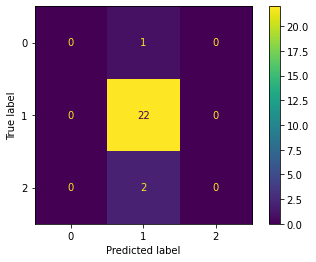

In [26]:
y_pred_rF = ranFor_CV.best_estimator_.predict(X_test)

print("Test accuracy:",accuracy_score(y_test,y_pred_rF))
cnf_matrix_rF = metrics.confusion_matrix(y_test, y_pred_rF)
plt.figure()
plot_confusion_matrix(ranFor_CV,X_test,y_test)